# Section 5

In [1]:
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt

plt.rcParams.update({
    "text.usetex": True,
    "font.family": "serif",
    "font.size": 16,
    'text.latex.preamble': r"\usepackage{amsmath}"
})

## Spectral function
Three Gaussians with parameters (position,width,weight) = (0,0.15,0.2),(±1,0.8,0.4).
The same spectrum was used in J. Otsuki et al., PRE 95, 061302(R) (2017).

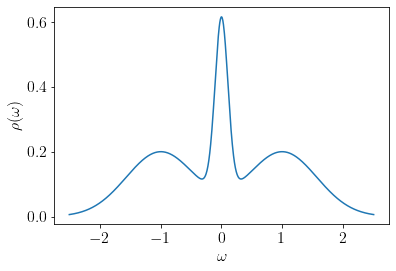

In [2]:
gaussian = lambda x, mu, sigma: np.exp(-((x-mu)/sigma)**2)/(np.sqrt(2*np.pi)*sigma)

rho = lambda omega: 0.2*gaussian(omega, 0.0, 0.15) + \
    0.4*gaussian(omega, 1.0, 0.8) + 0.4*gaussian(omega, -1.0, 0.8)

omegas = np.linspace(-2.5, 2.5, 1000)
plt.xlabel(r'$\omega$')
plt.ylabel(r'$\rho(\omega)$')
plt.plot(omegas, rho(omegas))


## Imaginary-time Green's function

We transform the spectral function to the Green's function using
$$
G(\tau) = - \int_{-\omega_\mathrm{max}}^{\omega_\mathrm{max}}d\tau K(\tau, \omega) \rho(\omega),
$$
where
$$
K(\tau, \omega) = \frac{e^{-\tau\omega}}{1+e^{-\beta\omega}}.
$$

When we discretize the kernel on uniform meshs for $\tau$ and $\omega$,
we obtain
$$
G(\tau_i) = - \frac{2\omega_\mathrm{max}}{N_\omega} \sum_j K(\tau_i, \omega_j) \rho(\omega_j) 
$$
for $i=1,2,\cdots,N_\tau$ and $j=1,2,\cdots,N_\omega$.
The cut-off frequency $\omega_\mathrm{max}$ must be large enough.
In this example, we use $\omega_\mathrm{max}=10$.

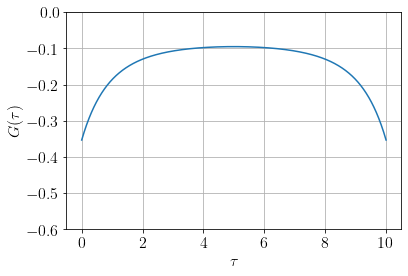

In [3]:
wmax = 10.0
beta = 10.0

nomega = 1000
ntau = 1000

omegas_mesh = np.linspace(-wmax, wmax, nomega)
taus_mesh = np.linspace(0, beta, ntau)

kernel = lambda tau, omega: np.exp(-tau*omega)/(1 + np.exp(-beta*omega))

kernel_val = kernel(taus_mesh[:,None], omegas_mesh[None,:])
gtau = - kernel_val @ rho(omegas_mesh) * (2*wmax/nomega)

plt.xlabel(r'$\tau$')
plt.ylabel(r'$G(\tau)$')
plt.ylim([-0.6,0])
plt.grid()
plt.plot(taus_mesh, gtau)

In [4]:
print(gtau[0])

-0.35319983720268056


## Reconstruction of spectral function

Can we reconstruct the original $\rho(\omega)$?
You might use
$$
\rho(\omega_j) = - \frac{N_\omega}{2\omega_\mathrm{max}} \sum_i (K^{-1})_{ji} G(\tau_j)
$$

.

''

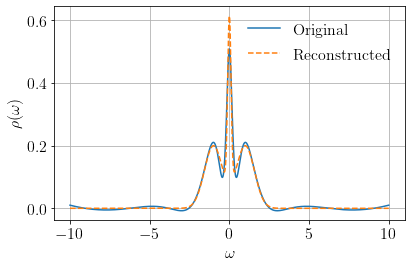

In [5]:
# OK, you get random data... (We actually used the pseudo inverse)
rho_reconst = -  (nomega/(2*wmax)) * np.linalg.pinv(kernel_val, rcond=1e-3) @ gtau
plt.plot(omegas_mesh, rho_reconst, label='Original')
plt.plot(omegas_mesh, rho(omegas_mesh), ls='--', label='Reconstructed')
plt.xlabel(r'$\omega$')
plt.grid()
plt.ylabel(r'$\rho(\omega)$')
plt.tight_layout()
plt.legend(loc='best', frameon=False)
plt.savefig('three_gaussian.pdf', transparent=True)
;

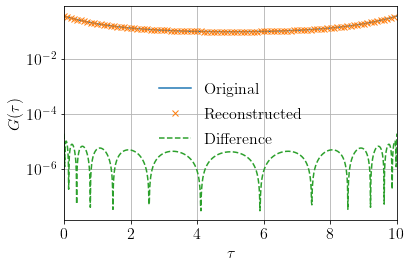

In [6]:
gtau_reconst = - kernel_val @ rho_reconst * (2*wmax/nomega)

plt.xlabel(r'$\tau$')
plt.ylabel(r'$G(\tau)$')
plt.xlim([0,beta])
#plt.ylim([-0.6,0])
plt.grid()
plt.plot(taus_mesh, -gtau, label='Original')
plt.plot(taus_mesh[::10], -gtau_reconst[::10], label='Reconstructed', ls='', marker='x')
plt.plot(taus_mesh, np.abs(gtau-gtau_reconst), ls='--', marker='', label='Difference')
plt.legend(loc='best', frameon=False)
plt.yscale("log")
plt.tight_layout()
plt.savefig('three_gaussian_gtau.pdf', transparent=True)

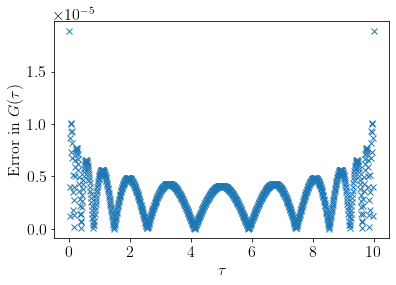

In [7]:
plt.xlabel(r'$\tau$')
plt.ylabel(r'Error in $G(\tau)$')
plt.plot(taus_mesh, np.abs(gtau-gtau_reconst), ls='', marker='x')

## Singular values

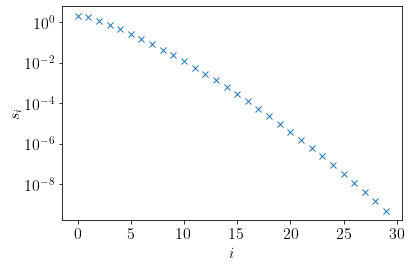

In [8]:
K = kernel_val * (2*wmax/nomega)
u, s, vh = np.linalg.svd(K)
plt.ylabel(r'$s_i$')
plt.xlabel(r'$i$')
plt.semilogy(s[:30], ls='', marker='x')
plt.tight_layout()
plt.savefig('kf_singular_vals.pdf', transparent=True)

## Singular vectors

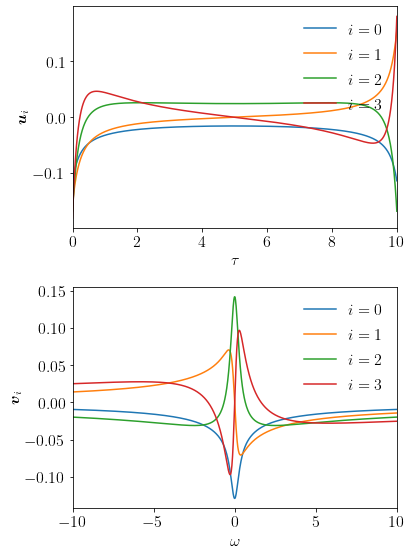

In [9]:
fig = plt.figure(figsize=(6,8))
ax1 = plt.subplot(211)
ax2 = plt.subplot(212)
axes = [ax1, ax2]

for i in range(4):
    ax1.plot(taus_mesh, u[:,i], label=f'$i={i}$')
    ax2.plot(omegas_mesh, vh[i,:], label=f'$i={i}$')

ax1.set_xlabel(r'$\tau$')
ax2.set_xlabel(r'$\omega$')
ax1.set_ylabel(r'$\boldsymbol{u}_i$')
ax2.set_ylabel(r'$\boldsymbol{v}_i$')
ax1.set_xlim([0,beta])
ax2.set_xlim([-wmax, wmax])

ax1.legend(loc='best', frameon=False)
ax2.legend(loc='best', frameon=False)
plt.tight_layout()
plt.savefig('kf_singular_vectors.pdf', transparent=True)

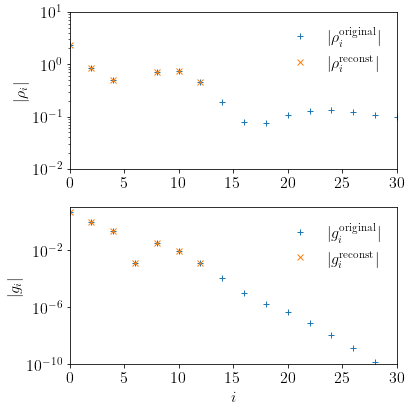

In [10]:
fig = plt.figure(figsize=(6,6))
ax1 = plt.subplot(211)
ax2 = plt.subplot(212, sharex = ax1)
axes = [ax1, ax2]

rhoi = vh @ rho(omegas_mesh)
rhoi_reconst = vh @ rho_reconst
gi = u.T @ gtau
gi_reconst = u.T @ gtau_reconst

ax2.set_xlabel(r'$i$')
ax1.set_ylabel(r'$|\rho_i|$')
ax2.set_ylabel(r'$|g_i|$')

x = np.arange(rhoi.size)
ax1.semilogy(x[::2], np.abs(rhoi)[::2], ls='', marker='+', label=r'$|\rho^\mathrm{original}_i|$')
ax1.semilogy(x[::2], np.abs(rhoi_reconst)[::2], ls='', marker='x', label=r'$|\rho^\mathrm{reconst}_i|$')
ax2.semilogy(x[::2], np.abs(gi)[::2], ls='', marker='+', label='$|g^\mathrm{original}_i|$')
ax2.semilogy(x[::2], np.abs(gi_reconst)[::2], ls='', marker='x', label='$|g^\mathrm{reconst}_i|$')
ax1.set_xlim([0,30])
ax1.set_ylim([1e-10,10])
ax1.set_ylim([1e-2,10])
ax2.set_ylim([1e-10,10])
ax1.legend(loc='best', frameon=False)
ax2.legend(loc='best', frameon=False)
plt.tight_layout()
plt.savefig('gi_rhoi.pdf', transparent=True)